In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# restrict warnings
import warnings
warnings.filterwarnings('ignore')

In [11]:
# import csv from data/data.csv
df = pd.read_csv('data/data.csv')
df.head()

,Name,Email,Student ID,Provider,Ingested Time,Retrieved Time
0,Kerry Tran,kerry.tran@marquette.edu,6249701,UPS,2023-12-14T19:17:42.000Z,2023-12-14T19:22:02.000Z
1,Kerry Tran,kerry.tran@marquette.edu,6249701,UPS,2023-12-14T19:17:17.000Z,2023-12-14T19:22:02.000Z
2,Olivia Fleming,olivia.fleming@marquette.edu,6257622,Amazon,2023-12-13T17:29:50.000Z,2023-12-14T20:31:12.000Z
3,Max Chruszczyk,max.chruszczyk@marquette.edu,6246869,Amazon,2023-12-13T17:29:23.000Z,2023-12-13T17:49:20.000Z
4,Charis Marquette,charis.marquette@marquette.edu,6268044,Amazon,2023-12-13T17:28:35.000Z,2023-12-13T21:35:53.000Z


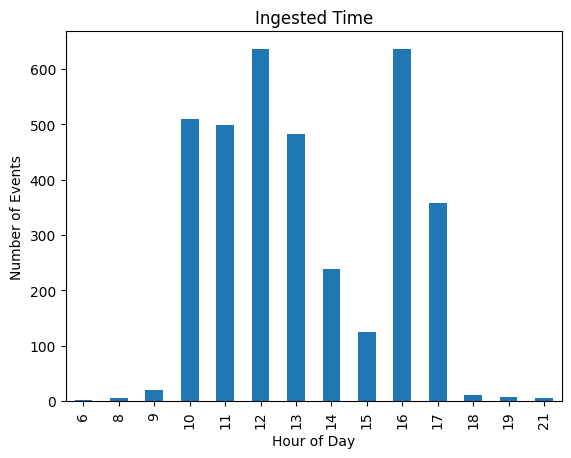

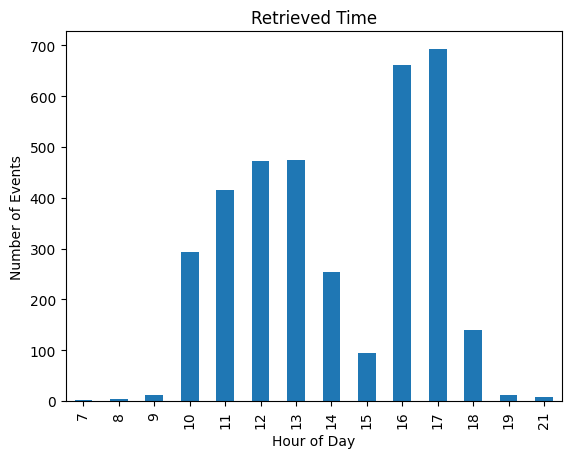

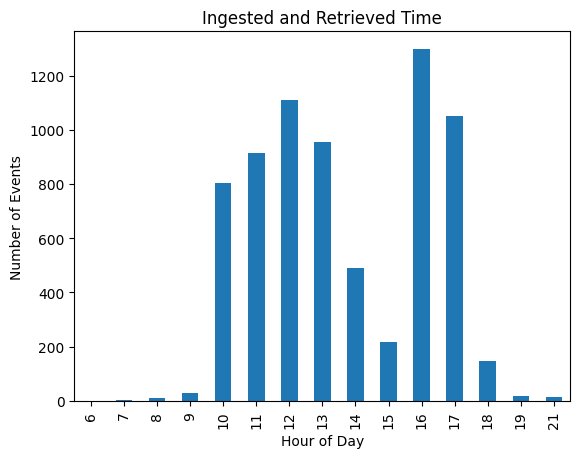

In [14]:
# make a bar chart of the hour of an event. each row has two events, the 'Ingested Time' and the 'Retrieved Time' column
# first split df into two dataframes, one for each event
df_ingested = df[['Ingested Time']]
df_retrieved = df[['Retrieved Time']]

# rename the columns to 'Time'
df_ingested.columns = ['Time']
df_retrieved.columns = ['Time']

# add a column to each dataframe that is the hour of the event. subtract 6 since the time is in UTC. this may go negative, so add 24 to make it positive
df_ingested['Hour'] = (pd.to_datetime(df_ingested['Time']) - pd.Timedelta(hours=6)).dt.hour
df_retrieved['Hour'] = (pd.to_datetime(df_retrieved['Time']) - pd.Timedelta(hours=6)).dt.hour

# make a bar chart of the hour of an event
fig, ax = plt.subplots()
df_ingested.groupby('Hour').count().plot(ax=ax, kind='bar', legend=False)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Number of Events')
ax.set_title('Ingested Time')
plt.show()

fig, ax = plt.subplots()
df_retrieved.groupby('Hour').count().plot(ax=ax, kind='bar', legend=False)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Number of Events')
ax.set_title('Retrieved Time')
plt.show()

# one for total number of events, ie just stack the bars
# combine dfs
df_total = pd.concat([df_ingested, df_retrieved], ignore_index=True)
fig, ax = plt.subplots()
df_total.groupby('Hour').count().plot(ax=ax, kind='bar', legend=False)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Number of Events')
ax.set_title('Ingested and Retrieved Time')
plt.show()

In [27]:
# calculate an "effective shift" by a group of events without more than an hour between them. graph the length and count of these shifts
# first sort by time
df_total.sort_values(by=['Time'], inplace=True)

# make time col of type datetime
df_total['Time'] = pd.to_datetime(df_total['Time'])

df_shifts = pd.DataFrame(columns=['Start Time', 'End Time', 'Length'])
# step through by row, calc the difference between the current row and the previous row. if the difference is more than an hour, then it's a new shift. add to df_shifts. otherewise, keep going and keep track of the first row in the shift
shift_start = df_total.iloc[0]['Time']
shift_end = df_total.iloc[0]['Time']
for index, row in df_total.iterrows():
    if (row['Time'] - shift_end) > pd.Timedelta(hours=1):
        # new shift
        df_shifts = df_shifts.append({'Start Time': shift_start, 'End Time': shift_end, 'Length': shift_end - shift_start}, ignore_index=True)
        shift_start = row['Time']
        shift_end = row['Time']
    else:
        shift_end = row['Time']
    
df_shifts.describe()

,Length
count,182
mean,0 days 01:37:07.296703296
std,0 days 01:16:08.415781346
min,0 days 00:00:00
25%,0 days 00:35:47.500000
50%,0 days 01:40:38
75%,0 days 02:00:32.750000
max,0 days 07:41:19


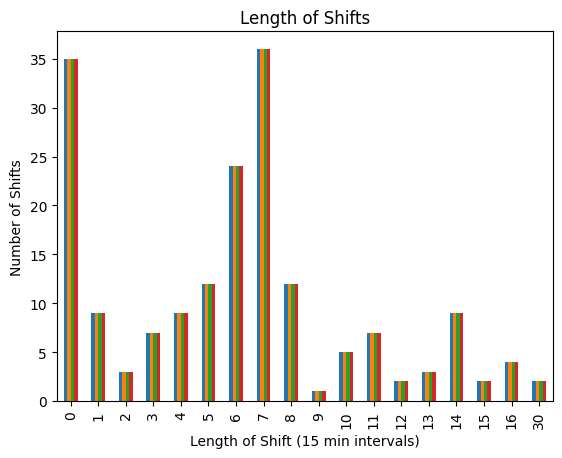

In [26]:
# plot shift lengths and counts
# first add a length as float column, use to group by in bar chart. groups should encapuslate 15 min intervals
df_shifts['Length Float'] = df_shifts['Length'].dt.total_seconds() / 60 / 15
df_shifts['Length Float'] = df_shifts['Length Float'].astype(int)

# plot
fig, ax = plt.subplots()
df_shifts.groupby('Length Float').count().plot(ax=ax, kind='bar', legend=False)
ax.set_xlabel('Length of Shift (15 min intervals)')
ax.set_ylabel('Number of Shifts')
ax.set_title('Length of Shifts')
plt.show()

In [33]:
# create a similar effect for "effective logging session", which only counts events from "ingested time"
# first sort by time
df_ingested.sort_values(by=['Time'], inplace=True)

# make time col of type datetime
df_ingested['Time'] = pd.to_datetime(df_ingested['Time'])

df_sessions = pd.DataFrame(columns=['Start Time', 'End Time', 'Length'])
# step through by row, calc the difference between the current row and the previous row. if the difference is more than an hour, then it's a new shift. add to df_shifts. otherewise, keep going and keep track of the first row in the shift
session_start = df_ingested.iloc[0]['Time']
session_end = df_ingested.iloc[0]['Time']
for index, row in df_ingested.iterrows():
    if (row['Time'] - session_end) > pd.Timedelta(hours=.5):
        # new shift
        df_sessions = df_sessions.append({'Start Time': session_start, 'End Time': session_end, 'Length': session_end - session_start}, ignore_index=True)
        session_start = row['Time']
        session_end = row['Time']
    else:
        session_end = row['Time']

df_sessions.describe()

,Length
count,215
mean,0 days 00:22:14.120930232
std,0 days 00:28:32.691283887
min,0 days 00:00:00
25%,0 days 00:01:08.500000
50%,0 days 00:11:15
75%,0 days 00:28:57.500000
max,0 days 02:40:51


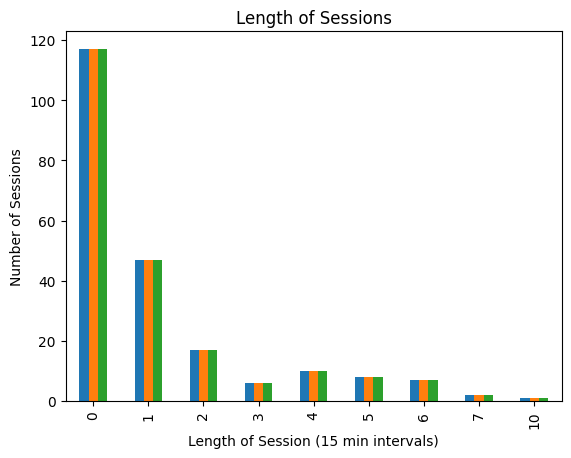

In [34]:
# create a similar groupby plot
# first add a length as float column, use to group by in bar chart. groups should encapuslate 15 min intervals
df_sessions['Length Float'] = df_sessions['Length'].dt.total_seconds() / 60 / 15
df_sessions['Length Float'] = df_sessions['Length Float'].astype(int)

# plot
fig, ax = plt.subplots()
df_sessions.groupby('Length Float').count().plot(ax=ax, kind='bar', legend=False)
ax.set_xlabel('Length of Session (15 min intervals)')
ax.set_ylabel('Number of Sessions')
ax.set_title('Length of Sessions')
plt.show()
